In [1]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import scipy
import os.path

In [2]:
def linearize_srgb(image: np.ndarray) -> np.ndarray:
    out = np.copy(image)
    under_threshold = image <= 0.04045
    over_threshold = np.logical_not(under_threshold)
    out[under_threshold] /= 12.92
    out[over_threshold] = np.power((image[over_threshold] + 0.055) / 1.055, 2.4)
    return out

def rgb_to_srgb(image: np.ndarray) -> np.ndarray:
    out = np.copy(image)
    under_threshold = image <= 0.0031308
    over_threshold = np.logical_not(under_threshold)
    
    out[under_threshold] *= 12.92
    out[over_threshold] = np.power(1.055 * image[over_threshold], 1 / 2.4) - 0.055

    return out

def rescaleToPercentile(image: np.ndarray, percentile: int):
    percentile = np.max(np.percentile(image, percentile, axis=(0,1)))
    image /= percentile
    image = np.clip(image, 0, 1, out=image)

# implements the greyworld algorithm as presented in "Color Constancy" (see paper reference "EbnerConstancy")
def greyWorld(image: Image.Image) -> Image.Image:
    floatImage = np.array(image, dtype=np.float32) / 255.0

    floatImage = linearize_srgb(floatImage)

    estimated_illumination = np.mean(floatImage, axis=(0,1))
    floatImage /= estimated_illumination

    # we rescale such that the top five percent of pixel values are clipped (in one of the channels)
    rescaleToPercentile(floatImage, 95)

    floatImage = rgb_to_srgb(floatImage)

    out_image_np = np.array(floatImage * 255, dtype=np.ubyte)
    return Image.fromarray(out_image_np)


In [3]:
# color correction as presented in "van2005color"
def greyEdge(image: Image.Image) -> Image.Image:
    floatImage = np.array(image, dtype=np.float32) / 255.0
    floatImage = linearize_srgb(floatImage)

    derivatives = np.empty_like(floatImage)
    for c in range(3):
        derivatives[:,:,c] = scipy.ndimage.gaussian_gradient_magnitude(floatImage[:,:,c], 3)
    estimated_illumination = np.mean(derivatives, axis=(0,1))
    floatImage /= estimated_illumination

    rescaleToPercentile(floatImage, 95)

    floatImage = rgb_to_srgb(floatImage)
    out_image_np = np.array(floatImage * 255, dtype=np.ubyte)
    return Image.fromarray(out_image_np)

In [4]:
# white patch from ebner's book
def whitePatch(image: Image.Image) -> Image.Image:
    floatImage = np.array(image, dtype=np.float32) / 255.0
    floatImage = linearize_srgb(floatImage)

    estimated_illumination = np.max(floatImage, axis=(0,1))
    floatImage /= estimated_illumination

    rescaleToPercentile(floatImage, 95)

    floatImage = rgb_to_srgb(floatImage)
    out_image_np = np.array(floatImage * 255, dtype=np.ubyte)
    return Image.fromarray(out_image_np)

In [5]:
def compareImage(path: str):
    img = Image.open(path)
    greyWorldImage = greyWorld(img)
    grayEdgeImage = greyEdge(img)
    whitePatchImage = whitePatch(img)

    fig = plt.figure(figsize=(10,10))

    ax = fig.add_subplot(2, 2, 1)
    ax.imshow(img)
    ax.set_title("Original")

    ax = fig.add_subplot(2, 2, 2)
    ax.imshow(greyWorldImage)
    ax.set_title("Grey World")

    ax = fig.add_subplot(2, 2, 3)
    ax.imshow(grayEdgeImage)
    ax.set_title("Grey Edge")

    ax = fig.add_subplot(2, 2, 4)
    ax.imshow(whitePatchImage)
    ax.set_title("White Patch")

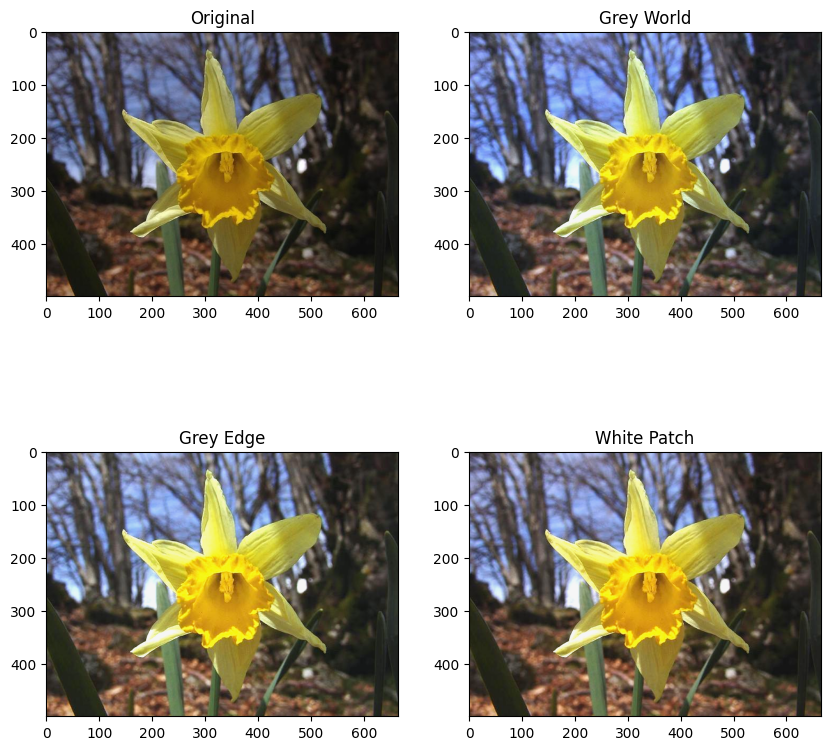

In [6]:
compareImage("../../data/17flowers/jpg/image_0002.jpg")

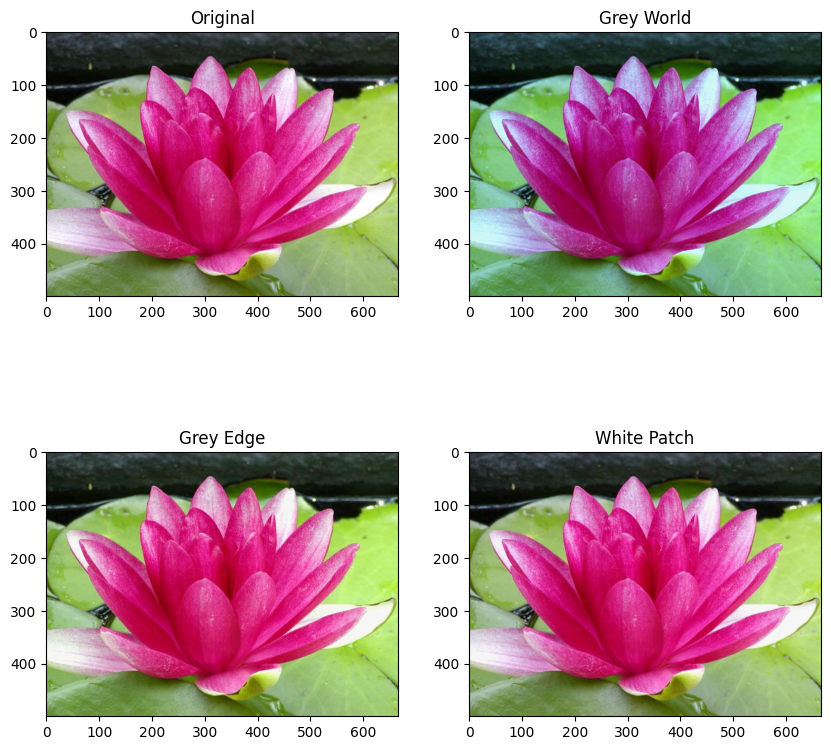

In [7]:
compareImage("../../data/102flowers/jpg/image_00254.jpg")

In [8]:
def processAndOutput(path: str, outFolder: str, base_name: str):
    img = Image.open(path)
    greyWorldImage = greyWorld(img)
    grayEdgeImage = greyEdge(img)
    whitePatchImage = whitePatch(img)

    img.save(os.path.join(outFolder, base_name+"_base.png"))
    greyWorldImage.save(os.path.join(outFolder, base_name+"_greyWorld.png"))
    grayEdgeImage.save(os.path.join(outFolder, base_name+"_grayEdge.png"))
    whitePatchImage.save(os.path.join(outFolder, base_name+"_whitePatch.png"))

In [9]:
processAndOutput("../../data/17flowers/jpg/image_0001.jpg", ".", "flower001")
processAndOutput("../../data/17flowers/jpg/image_0268.jpg", ".", "flower268")

NameError: name 'os' is not defined